Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]



===== RUN SEED 0 =====
VAE Epoch 1: train 56.123381, val 42.339019
VAE Epoch 2: train 34.073691, val 29.391055
VAE Epoch 3: train 27.161917, val 25.638410
VAE Epoch 4: train 24.712113, val 24.277073
VAE Epoch 5: train 23.637311, val 23.399518
VAE Epoch 6: train 22.997862, val 22.915379
VAE Epoch 7: train 22.604936, val 22.612815
VAE Epoch 8: train 22.262977, val 22.400752
VAE Epoch 9: train 22.042524, val 22.165517
VAE Epoch 10: train 21.834447, val 21.899506
VAE Epoch 11: train 21.636240, val 21.806290
VAE Epoch 12: train 21.487416, val 21.606767
VAE Epoch 13: train 21.382513, val 21.524947
VAE Epoch 14: train 21.268004, val 21.490109
VAE Epoch 15: train 21.199433, val 21.380120
VAE Epoch 16: train 21.102785, val 21.385578
VAE Epoch 17: train 21.008626, val 21.236364
VAE Epoch 18: train 20.950467, val 21.161249
VAE Epoch 19: train 20.831462, val 21.083046
VAE Epoch 20: train 20.793531, val 21.095910
VAE Epoch 21: train 20.742279, val 21.012757
VAE Epoch 22: train 20.710819, val 21.05

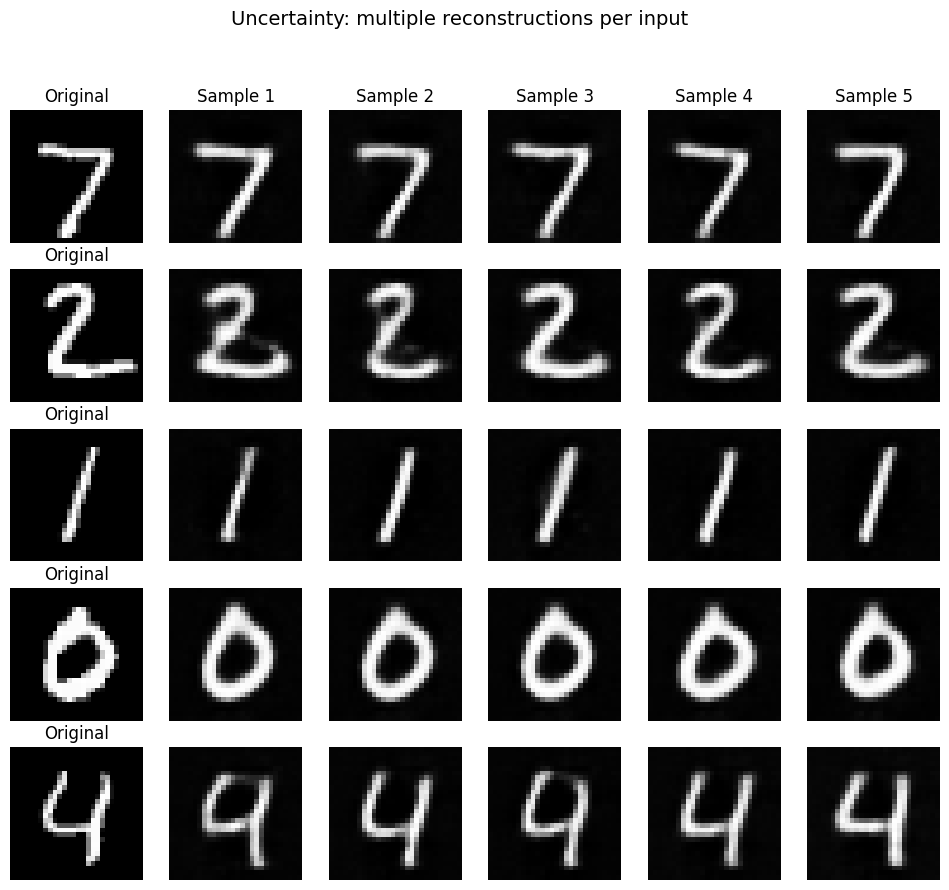


===== RUN SEED 1 =====
VAE Epoch 1: train 55.252473, val 42.815238
VAE Epoch 2: train 34.322880, val 29.502004
VAE Epoch 3: train 27.145107, val 25.660226
VAE Epoch 4: train 24.688394, val 24.149869
VAE Epoch 5: train 23.640834, val 23.467097
VAE Epoch 6: train 23.011191, val 22.947870
VAE Epoch 7: train 22.616982, val 22.778618
VAE Epoch 8: train 22.308129, val 22.350521
VAE Epoch 9: train 22.067035, val 22.085160
VAE Epoch 10: train 21.899278, val 22.041480
VAE Epoch 11: train 21.683130, val 21.849239
VAE Epoch 12: train 21.550665, val 21.652663
VAE Epoch 13: train 21.409194, val 21.571446
VAE Epoch 14: train 21.301414, val 21.468968
VAE Epoch 15: train 21.194687, val 21.443563
VAE Epoch 16: train 21.101856, val 21.329970
VAE Epoch 17: train 21.030167, val 21.212919
VAE Epoch 18: train 20.933812, val 21.209902
VAE Epoch 19: train 20.874434, val 21.192504
VAE Epoch 20: train 20.795923, val 21.056670
VAE Epoch 21: train 20.751313, val 21.067919
VAE Epoch 22: train 20.690058, val 20.99

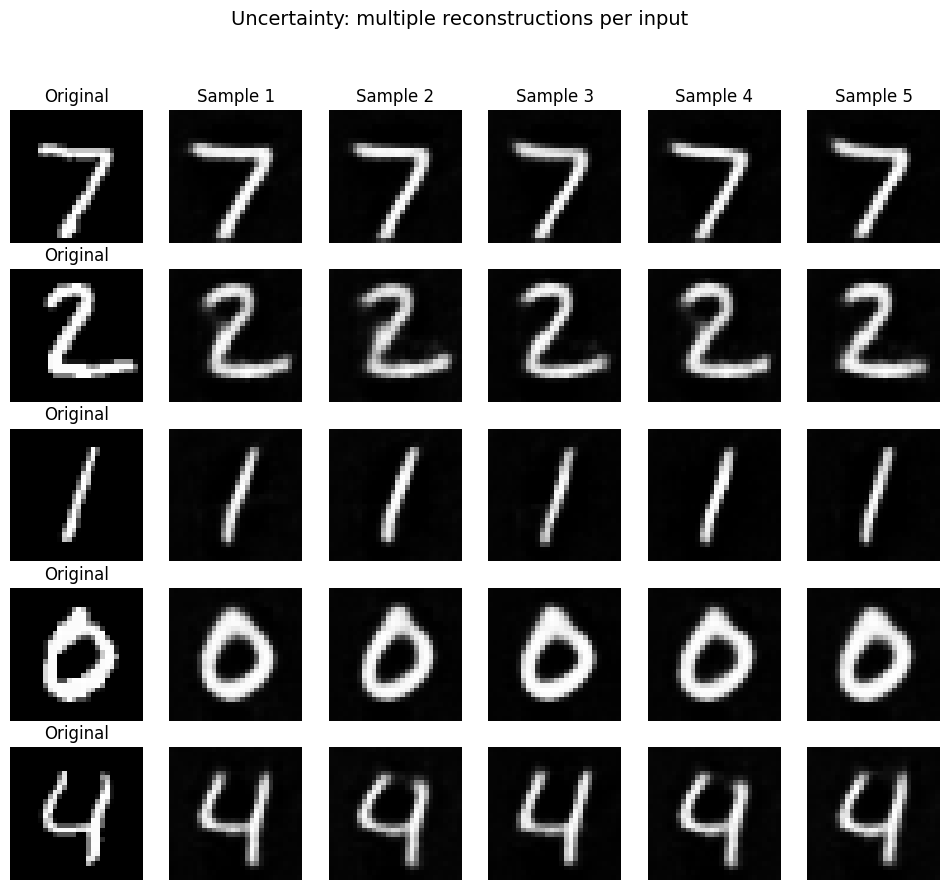


===== RUN SEED 2 =====
VAE Epoch 1: train 55.576804, val 42.788454
VAE Epoch 2: train 35.109283, val 30.117701
VAE Epoch 3: train 27.765121, val 26.036537
VAE Epoch 4: train 25.044759, val 24.415004
VAE Epoch 5: train 23.837315, val 23.570836
VAE Epoch 6: train 23.141449, val 23.034827
VAE Epoch 7: train 22.665223, val 22.560114
VAE Epoch 8: train 22.325323, val 22.375657
VAE Epoch 9: train 22.039790, val 22.096026
VAE Epoch 10: train 21.821840, val 21.895927
VAE Epoch 11: train 21.641335, val 21.820010
VAE Epoch 12: train 21.496349, val 21.630542
VAE Epoch 13: train 21.340203, val 21.561090
VAE Epoch 14: train 21.217088, val 21.369669
VAE Epoch 15: train 21.118224, val 21.427092
VAE Epoch 16: train 21.010089, val 21.125475
VAE Epoch 17: train 20.928738, val 21.060832
VAE Epoch 18: train 20.848011, val 21.090829
VAE Epoch 19: train 20.783896, val 21.091641
VAE Epoch 20: train 20.722571, val 20.964660
VAE Epoch 21: train 20.641995, val 20.965791
VAE Epoch 22: train 20.581730, val 20.78

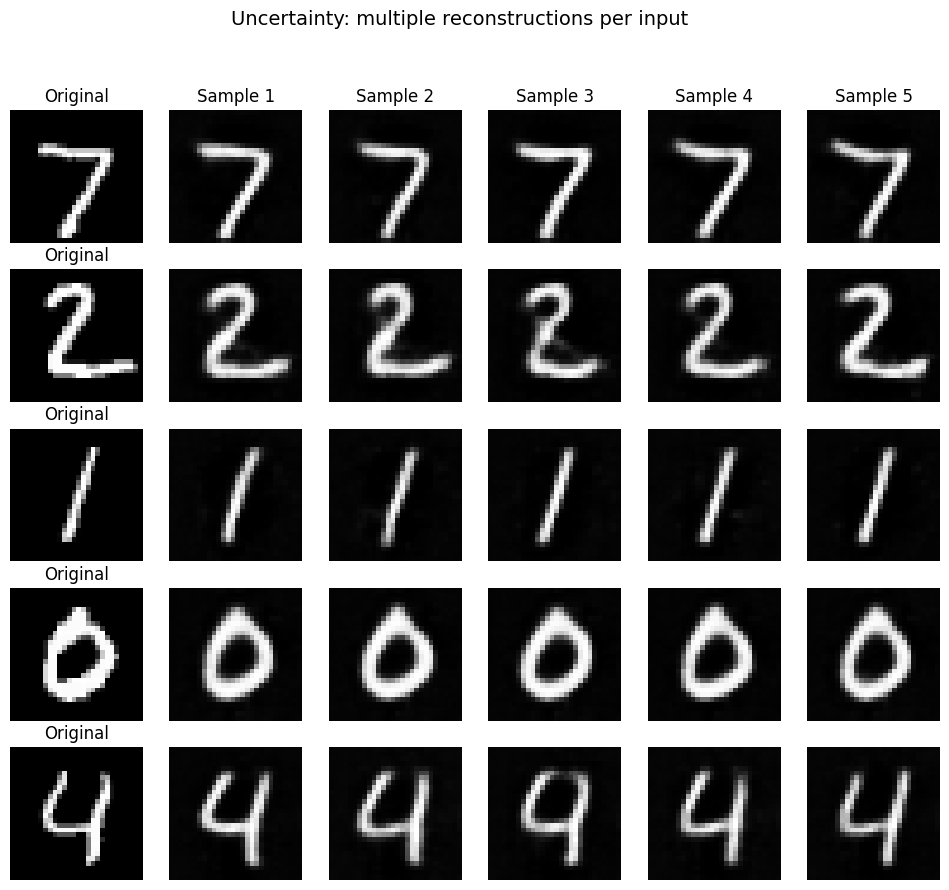


===== AVERAGE OVER SEEDS =====
VAE: {'silhouette': 0.09071071694294612, 'ari': 0.5663191416456462, 'nmi': 0.6302996335181229, 'recon_mse': 0.013736971033116182}
AE: {'silhouette': 0.14129401246706644, 'ari': 0.48446323566451005, 'nmi': 0.5951036847957204, 'recon_mse': 0.006841123880197604}


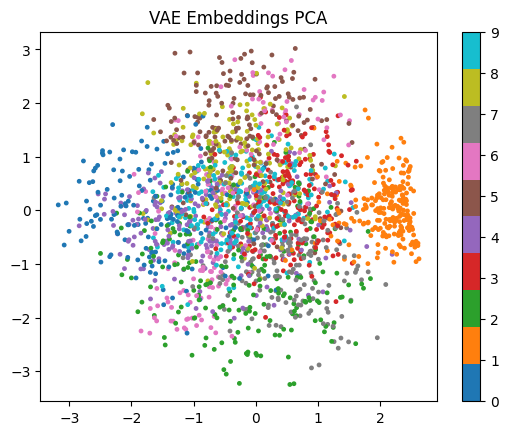

In [ ]:
!pip install torch torchvision scikit-learn matplotlib scipy

import os, random, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

config = {
    "latent_dim": 20,
    "num_clusters": 10,
    "batch_size": 256,
    "vae_epochs": 30,
    "ae_epochs": 20,
    "beta": 0.5,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "patience": 6,
    "num_seeds": 3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # ensure reproducibility of dataloader workers too
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.05, 0.0, 1.0))
])
transform_test = transforms.ToTensor()

full_train = datasets.MNIST(root="./data", train=True, transform=transform_train, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform_test, download=True)

# Split train -> train+val (90/10)
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

# worker init fn for DataLoader so transforms that use RNG are reproducible
def worker_init_fn(worker_id):
    # seed each worker deterministically from main seed
    base_seed = torch.initial_seed() % 2**32
    np.random.seed(base_seed + worker_id)
    random.seed(base_seed + worker_id)

def get_loaders(batch_size, num_workers=2):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              pin_memory=True, num_workers=num_workers, worker_init_fn=worker_init_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            pin_memory=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             pin_memory=True, num_workers=num_workers)
    return train_loader, val_loader, test_loader

# models
class VAE(nn.Module):
    def __init__(self, latent_dim=20, num_clusters=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_clusters = num_clusters

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 64*7*7), nn.ReLU(),
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, latent_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)


    def reparameterize(self, mu, logvar):

        logvar = torch.clamp(logvar, min=-15.0, max=15.0)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

class AE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7), nn.ReLU(),
            nn.Unflatten(1, (64,7,7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

# init weights
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# loss functions
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    batch = x.size(0)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch
    return recon_loss + beta * kld, recon_loss, kld

# clustering label mapping using Hungarian algorithm
def cluster_label_mapping(true_labels, pred_labels, n_clusters=None):
    true_labels = np.asarray(true_labels, dtype=np.int64)
    pred_labels = np.asarray(pred_labels, dtype=np.int64)
    n_clusters = n_clusters if n_clusters is not None else (pred_labels.max() + 1)
    n_classes = int(true_labels.max() + 1)

    cm = np.zeros((n_clusters, n_classes), dtype=np.int64)
    for p, t in zip(pred_labels, true_labels):
        cm[p, t] += 1

    # pad cm to make it square if needed
    if cm.shape[0] != cm.shape[1]:
        size = max(cm.shape)
        cm2 = np.zeros((size, size), dtype=np.int64)
        cm2[:cm.shape[0], :cm.shape[1]] = cm
        cm = cm2

    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {}
    for r, c in zip(row_ind, col_ind):
        if c < n_classes:
            mapping[r] = c
    mapped = np.array([mapping.get(p, -1) for p in pred_labels], dtype=np.int64)
    return mapped

# training functions
def train_vae(model, train_loader, val_loader, optimizer, beta, epochs, patience, save_path="best_vae.pth"):
    best_loss, wait = float("inf"), 0
    for epoch in range(epochs):
        model.train()
        total = 0.0
        n_samples = 0
        for x,_ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, z = model(x)
            loss,_,_ = vae_loss(recon,x,mu,logvar,beta)
            loss.backward(); optimizer.step()
            batch_size = x.size(0)
            total += float(loss.item()) * batch_size  # accumulate weighted sum
            n_samples += batch_size
        train_loss = total / n_samples

        # validation
        model.eval(); val_total=0.0; val_n=0
        with torch.no_grad():
            for x,_ in val_loader:
                x = x.to(device)
                recon, mu, logvar, z = model(x)
                loss,_,_ = vae_loss(recon,x,mu,logvar,beta)
                val_total += float(loss.item()) * x.size(0)
                val_n += x.size(0)
        val_loss = val_total / val_n
        print(f"VAE Epoch {epoch+1}: train {train_loss:.6f}, val {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss; wait = 0
            torch.save(model.state_dict(), save_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping VAE"); break


def train_ae(model, train_loader, val_loader, optimizer, epochs, patience, save_path="best_ae.pth"):
    best_loss, wait = float("inf"), 0
    for epoch in range(epochs):
        model.train(); total=0.0; n_samples=0
        for x,_ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon, z = model(x)
            loss = F.mse_loss(recon, x, reduction="sum")  # sum for sample-weighted averaging
            loss.backward(); optimizer.step()
            total += float(loss.item())
            n_samples += x.size(0)
        train_loss = total / n_samples

        model.eval(); val_total=0.0; val_n=0
        with torch.no_grad():
            for x,_ in val_loader:
                x = x.to(device)
                recon, z = model(x)
                loss = F.mse_loss(recon, x, reduction="sum")
                val_total += float(loss.item())
                val_n += x.size(0)
        val_loss = val_total / val_n
        print(f"AE Epoch {epoch+1}: train {train_loss:.6f}, val {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss; wait = 0
            torch.save(model.state_dict(), save_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping AE"); break




# visualize_uncertainty
def visualize_uncertainty(model, loader, n=5, k=5, save_path=None):
    """
    Show uncertainty: pick n inputs and generate k stochastic reconstructions for each.
    """
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)

    fig, axes = plt.subplots(n, k+1, figsize=(2*(k+1), 2*n))
    with torch.no_grad():
        for i in range(n):
            axes[i,0].imshow(x[i,0].cpu().numpy(), cmap="gray")
            axes[i,0].set_title("Original"); axes[i,0].axis("off")

            mu, logvar = model.encode(x[i].unsqueeze(0))
            for j in range(k):
                z = model.reparameterize(mu, logvar)
                recon = model.decode(z).cpu().numpy()[0,0]
                axes[i,j+1].imshow(recon, cmap="gray")
                axes[i,j+1].axis("off")
                if i == 0: axes[i,j+1].set_title(f"Sample {j+1}")

    plt.suptitle("Uncertainty: multiple reconstructions per input", fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


# evaluation function

def evaluate_embeddings(model, loader, num_clusters, vae=True, return_embs=False):
    model.eval()
    embs = []; recons = []; labels = []; inputs = []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            inputs.append(x.cpu().numpy())
            if vae:
                recon, mu, logvar, z = model(x); embs.append(mu.cpu().numpy())
            else:
                recon, z = model(x); embs.append(z.cpu().numpy())
            recons.append(recon.cpu().numpy())
            labels.extend(y.numpy())
    embeddings = np.vstack(embs)
    recons = np.vstack(recons)
    inputs = np.vstack(inputs)
    labels = np.array(labels)

    # clustering + metrics
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    preds = kmeans.fit_predict(embeddings)
    mapped = cluster_label_mapping(labels, preds, n_clusters=num_clusters)
    sil = silhouette_score(embeddings, preds) if len(np.unique(preds)) > 1 else float("nan")
    ari = adjusted_rand_score(labels, mapped)
    nmi = normalized_mutual_info_score(labels, mapped)
    mse = float(np.mean((recons - inputs) ** 2))

    result = {"silhouette": float(sil), "ari": float(ari), "nmi": float(nmi), "recon_mse": float(mse)}
    if return_embs:
        result["embeddings"] = embeddings
        result["labels"] = labels
    return result


# main experiment loop
os.makedirs("outputs",exist_ok=True)
all_results={"vae":[],"ae":[]}

for seed in range(config["num_seeds"]):
    print(f"\n===== RUN SEED {seed} =====")
    set_seed(seed)
    train_loader,val_loader,test_loader=get_loaders(config["batch_size"])

    # VAE
    vae=VAE(config["latent_dim"],config["num_clusters"]).to(device)
    vae.apply(init_weights)
    opt=optim.Adam(vae.parameters(),lr=config["lr"],weight_decay=config["weight_decay"])
    
    train_vae(
    vae, train_loader, val_loader, opt,
    config["beta"], config["vae_epochs"], config["patience"],
    save_path=f"best_vae_seed{seed}.pth"
    )
    vae.load_state_dict(torch.load(f"best_vae_seed{seed}.pth", map_location=device))
    
    if seed == 0:
        res_vae = evaluate_embeddings(vae, test_loader, config["num_clusters"], vae=True, return_embs=True)
    else:
        res_vae = evaluate_embeddings(vae, test_loader, config["num_clusters"], vae=True, return_embs=False)

    print("VAE metrics:", {k: v for k,v in res_vae.items() if k not in ["embeddings","labels"]})
    all_results["vae"].append(res_vae)



    # AE
    ae=AE(config["latent_dim"]).to(device)
    ae.apply(init_weights)
    opt=optim.Adam(ae.parameters(),lr=config["lr"])
    
    train_ae(
    ae, train_loader, val_loader, opt,
    config["ae_epochs"], config["patience"],
    save_path=f"best_ae_seed{seed}.pth"
    )
    ae.load_state_dict(torch.load(f"best_ae_seed{seed}.pth", map_location=device))
    res_ae=evaluate_embeddings(ae,test_loader,config["num_clusters"],vae=False)
    print("AE metrics:",res_ae); all_results["ae"].append(res_ae)
    # Uncertainty visualization
    visualize_uncertainty(vae, test_loader, n=5, k=5, save_path="outputs/vae_uncertainty.png")


# results summary
def avg_metrics(results):
    numeric = {}
    for res in results:
        for k, v in res.items():
            if isinstance(v, (int, float, np.floating, np.integer)):
                numeric.setdefault(k, []).append(float(v))
    return {k: float(np.mean(vals)) for k, vals in numeric.items()}


vae_avg=avg_metrics(all_results["vae"])
ae_avg=avg_metrics(all_results["ae"])
print("\n===== AVERAGE OVER SEEDS =====")
print("VAE:",vae_avg); print("AE:",ae_avg)

with open("outputs/results_summary.json","w") as f: json.dump({"vae":vae_avg,"ae":ae_avg},f,indent=2)

# PCA visualization of VAE embeddings
vae_first = all_results["vae"][0]
vae_embeddings = vae_first["embeddings"]
vae_labels = vae_first["labels"]

pca = PCA(2).fit_transform(vae_embeddings[:2000])
plt.scatter(pca[:,0], pca[:,1], c=vae_labels[:2000], cmap="tab10", s=6)

plt.colorbar(); plt.title("VAE Embeddings PCA")
plt.savefig("outputs/vae_pca.png",dpi=200); plt.show()


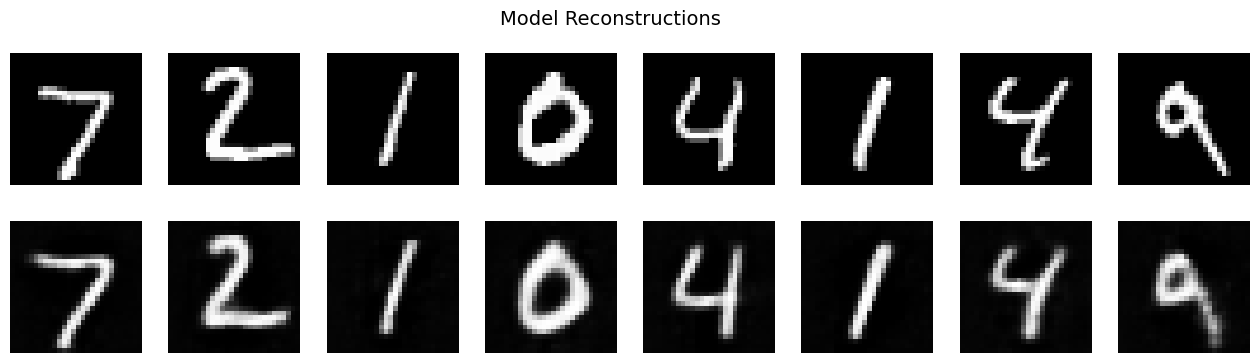

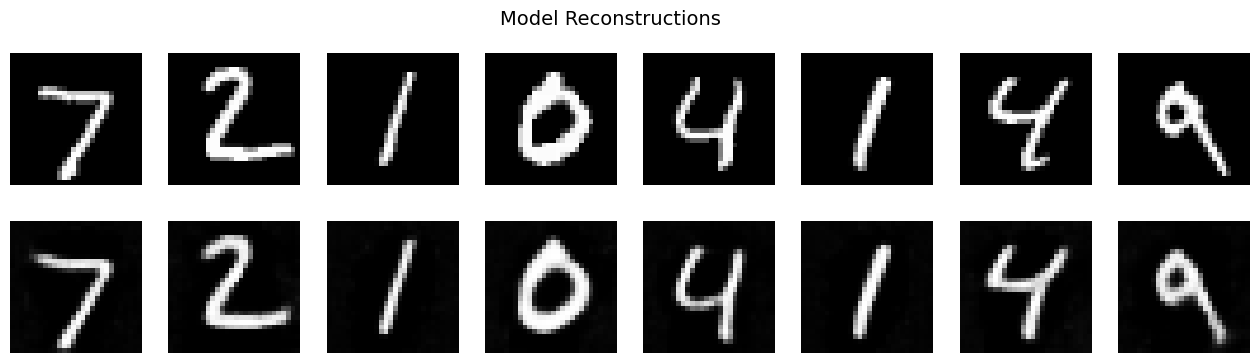

In [ ]:
# Reconstruction visualization
def show_reconstructions(model, loader, vae=True, n=8, save_path=None):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)

    with torch.no_grad():
        if vae:
            recon, mu, logvar, z = model(x)
        else:
            recon, z = model(x)

    x = x.cpu().numpy()
    recon = recon.cpu().numpy()

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        # Original
        axes[0, i].imshow(x[i, 0], cmap="gray")
        axes[0, i].axis("off")
        # Reconstructed
        axes[1, i].imshow(recon[i, 0], cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.suptitle("Model Reconstructions", fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


show_reconstructions(vae, test_loader, vae=True, n=8, save_path="outputs/vae_recon.png")
show_reconstructions(ae, test_loader, vae=False, n=8, save_path="outputs/ae_recon.png")


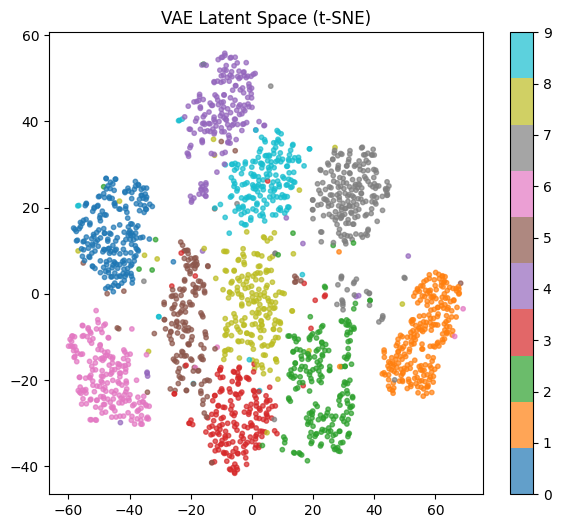

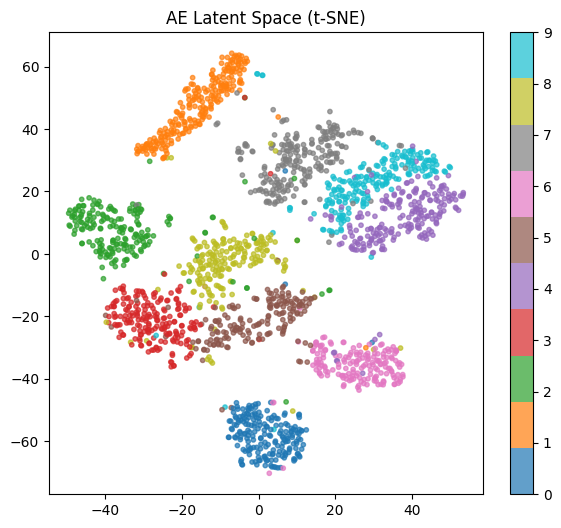

In [ ]:
# t-SNE visualization of latent space
from sklearn.manifold import TSNE

def plot_latent_space(embeddings, labels, title="Latent Space", save_path=None, n_samples=2000):
    # Subsample for speed/clarity
    idx = np.random.choice(len(embeddings), size=min(n_samples, len(embeddings)), replace=False)
    embs_sub = embeddings[idx]
    labels_sub = labels[idx]

    # t-SNE
    tsne = TSNE(n_components=2, init="random", random_state=0, perplexity=30, learning_rate=200)
    embs_2d = tsne.fit_transform(embs_sub)

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(embs_2d[:,0], embs_2d[:,1], c=labels_sub, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


# Use embeddings from the first run (seed=0)
vae_first = all_results["vae"][0]
plot_latent_space(
    vae_first["embeddings"],
    vae_first["labels"],
    title="VAE Latent Space (t-SNE)",
    save_path="outputs/vae_tsne.png"
)


ae_res = evaluate_embeddings(ae, test_loader, config["num_clusters"], vae=False, return_embs=True)
plot_latent_space(
    ae_res["embeddings"],
    ae_res["labels"],
    title="AE Latent Space (t-SNE)",
    save_path="outputs/ae_tsne.png"
)


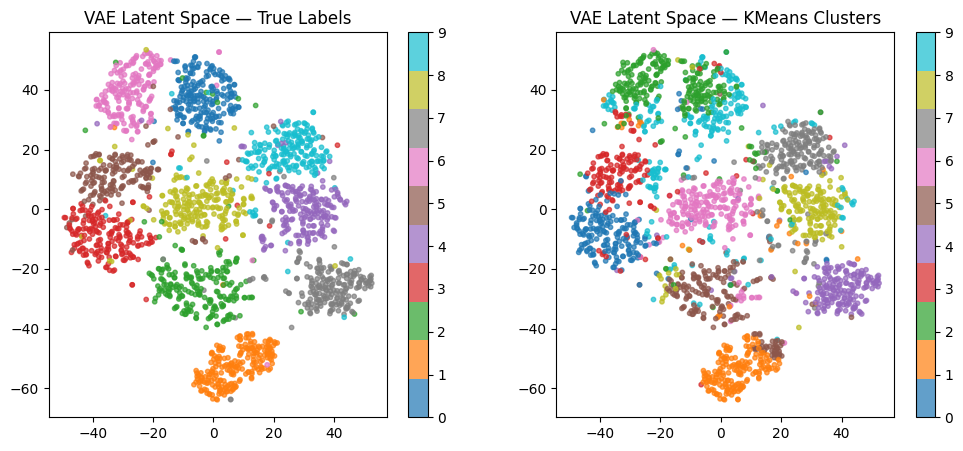

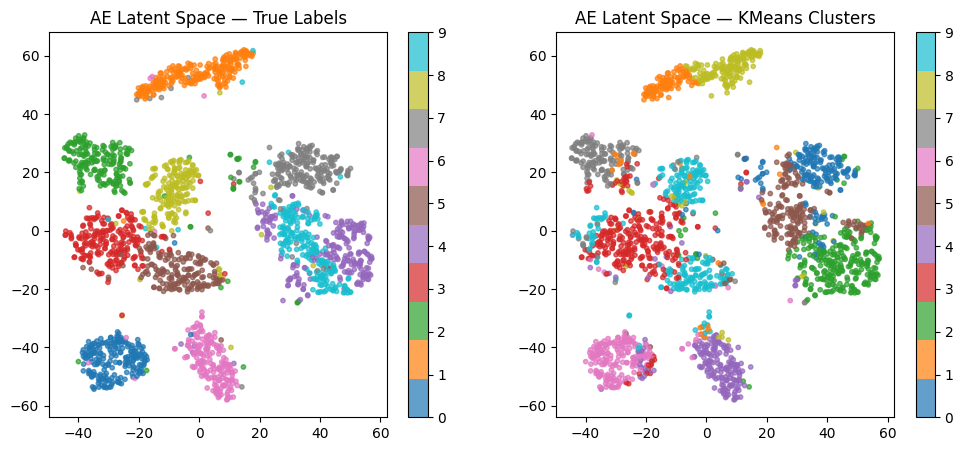

In [ ]:
def plot_latent_clusters(embeddings, labels_true, n_clusters, title="Clustering", save_path=None, n_samples=2000):
    # Subsample for speed/clarity
    idx = np.random.choice(len(embeddings), size=min(n_samples, len(embeddings)), replace=False)
    embs_sub = embeddings[idx]
    labels_true_sub = labels_true[idx]

    # Reduce to 2D
    tsne = TSNE(n_components=2, init="random", random_state=0, perplexity=30, learning_rate=200)
    embs_2d = tsne.fit_transform(embs_sub)

    # Run KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    preds = kmeans.fit_predict(embs_sub)

    # Plot true labels
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    scatter1 = plt.scatter(embs_2d[:,0], embs_2d[:,1], c=labels_true_sub, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter1, ticks=range(10))
    plt.title(title + " — True Labels")

    # Plot predicted clusters
    plt.subplot(1,2,2)
    scatter2 = plt.scatter(embs_2d[:,0], embs_2d[:,1], c=preds, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter2, ticks=range(n_clusters))
    plt.title(title + " — KMeans Clusters")

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()



vae_first = all_results["vae"][0]
plot_latent_clusters(
    vae_first["embeddings"],
    vae_first["labels"],
    config["num_clusters"],
    title="VAE Latent Space",
    save_path="outputs/vae_clusters.png"
)

# 
ae_res = evaluate_embeddings(ae, test_loader, config["num_clusters"], vae=False, return_embs=True)
plot_latent_clusters(
    ae_res["embeddings"],
    ae_res["labels"],
    config["num_clusters"],
    title="AE Latent Space",
    save_path="outputs/ae_clusters.png"
)


In [5]:
# #
# def visualize_uncertainty(model, loader, n=5, k=5, save_path=None):
#     """
#     Show uncertainty: pick n inputs and generate k stochastic reconstructions for each.
#     """
#     model.eval()
#     x, _ = next(iter(loader))
#     x = x[:n].to(device)

#     fig, axes = plt.subplots(n, k+1, figsize=(2*(k+1), 2*n))
#     with torch.no_grad():
#         for i in range(n):
#             axes[i,0].imshow(x[i,0].cpu().numpy(), cmap="gray")
#             axes[i,0].set_title("Original"); axes[i,0].axis("off")

#             mu, logvar = model.encode(x[i].unsqueeze(0))
#             for j in range(k):
#                 z = model.reparameterize(mu, logvar)
#                 recon = model.decode(z).cpu().numpy()[0,0]
#                 axes[i,j+1].imshow(recon, cmap="gray")
#                 axes[i,j+1].axis("off")
#                 if i == 0: axes[i,j+1].set_title(f"Sample {j+1}")

#     plt.suptitle("Uncertainty: multiple reconstructions per input", fontsize=14)
#     if save_path:
#         plt.savefig(save_path, dpi=200, bbox_inches="tight")
#     plt.show()


In [ ]:
# 
def summarize_metrics(all_results):
    """
    Compute mean and std for each metric across seeds.
    """
    summary = {}
    for model, results in all_results.items():
        metrics = {}
        for res in results:
            for k,v in res.items():
                if isinstance(v,(int,float,np.floating)):
                    metrics.setdefault(k,[]).append(float(v))
        summary[model] = {
            k: {"mean": np.mean(vs), "std": np.std(vs)} for k,vs in metrics.items()
        }
    return summary

summary = summarize_metrics(all_results)

print("\n===== METRICS SUMMARY (mean ± std) =====")
for model, metrics in summary.items():
    print(f"\n{model.upper()}:")
    for k,vals in metrics.items():
        print(f"  {k}: {vals['mean']:.4f} ± {vals['std']:.4f}")



===== METRICS SUMMARY (mean ± std) =====

VAE:
  silhouette: 0.0907 ± 0.0023
  ari: 0.5663 ± 0.0490
  nmi: 0.6303 ± 0.0336
  recon_mse: 0.0137 ± 0.0002

AE:
  silhouette: 0.1413 ± 0.0066
  ari: 0.4845 ± 0.0409
  nmi: 0.5951 ± 0.0293
  recon_mse: 0.0068 ± 0.0000


In [7]:
#
import pandas as pd

rows = []
for seed in range(config["num_seeds"]):
    rows.append({"Seed": seed, "Model": "VAE", **all_results["vae"][seed]})
    rows.append({"Seed": seed, "Model": "AE",  **all_results["ae"][seed]})

# Add averages
vae_avg = {k: np.mean([r[k] for r in all_results["vae"]]) for k in all_results["vae"][0] if isinstance(all_results["vae"][0][k], (int,float))}
ae_avg  = {k: np.mean([r[k] for r in all_results["ae"]]) for k in all_results["ae"][0] if isinstance(all_results["ae"][0][k], (int,float))}
rows.append({"Seed":"Avg","Model":"VAE",**vae_avg})
rows.append({"Seed":"Avg","Model":"AE",**ae_avg})

df = pd.DataFrame(rows)
print("\n===== COMPARISON TABLE =====")
print(df.round(4).to_string(index=False))

# Save for report
df.to_csv("outputs/metrics_comparison.csv", index=False)
with open("outputs/metrics_comparison.tex","w") as f:
    f.write(df.to_latex(index=False, float_format="%.4f"))



===== COMPARISON TABLE =====
Seed Model  silhouette    ari    nmi  recon_mse                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [8]:
#

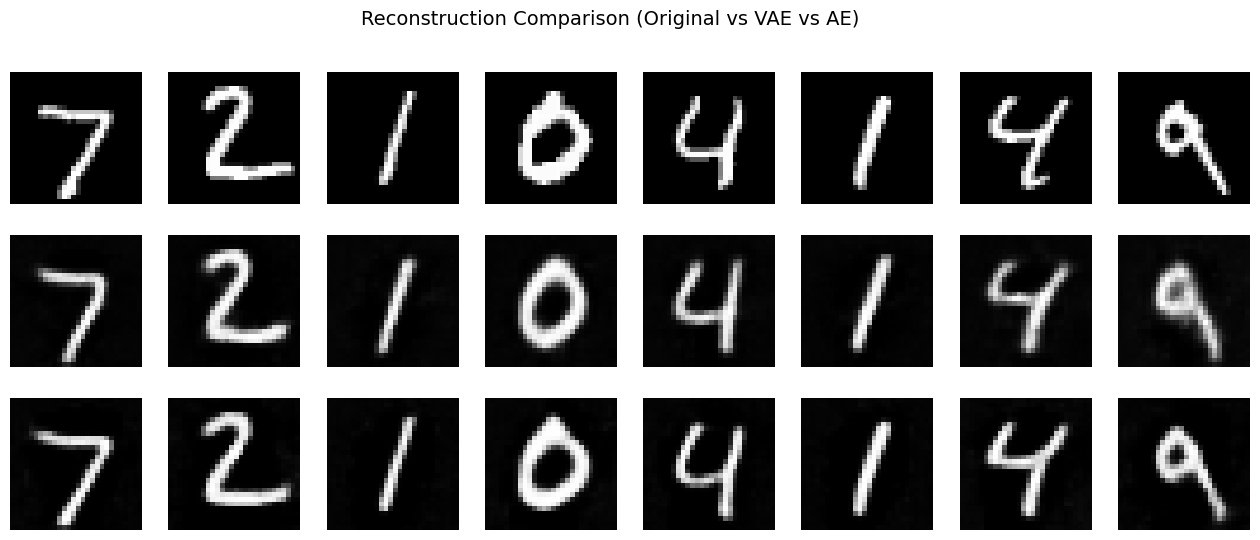

In [ ]:
#  comparison of reconstructions
def compare_reconstructions(vae, ae, loader, n=8, save_path=None):
    vae.eval(); ae.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)

    with torch.no_grad():
        recon_vae, mu, logvar, z = vae(x)
        recon_ae, z_ae = ae(x)

    x = x.cpu().numpy()
    recon_vae = recon_vae.cpu().numpy()
    recon_ae = recon_ae.cpu().numpy()

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    for i in range(n):
        # Original
        axes[0, i].imshow(x[i, 0], cmap="gray")
        axes[0, i].axis("off")

        # VAE reconstruction
        axes[1, i].imshow(recon_vae[i, 0], cmap="gray")
        axes[1, i].axis("off")

        # AE reconstruction
        axes[2, i].imshow(recon_ae[i, 0], cmap="gray")
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("VAE", fontsize=12)
    axes[2, 0].set_ylabel("AE", fontsize=12)

    plt.suptitle("Reconstruction Comparison (Original vs VAE vs AE)", fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


# ==== Example usage ====
compare_reconstructions(vae, ae, test_loader, n=8, save_path="outputs/recon_comparison.png")


In [ ]:
from tabulate import tabulate  # pip install tabulate if not already

# results summary with averages
def avg_metrics(results):
    numeric = {}
    for res in results:
        for k, v in res.items():
            if isinstance(v, (int, float, np.floating, np.integer)):
                numeric.setdefault(k, []).append(float(v))
    return {k: float(np.mean(vals)) for k, vals in numeric.items()}

vae_avg = avg_metrics(all_results["vae"])
ae_avg = avg_metrics(all_results["ae"])

print("\n===== AVERAGE OVER SEEDS =====")
print("VAE:", vae_avg); print("AE:", ae_avg)

with open("outputs/results_summary.json","w") as f:
    json.dump({"vae":vae_avg,"ae":ae_avg}, f, indent=2)

# tabulated comparison table
headers = ["Seed", "Model", "MSE", "ARI", "NMI", "Silhouette"]
table = []

for seed in range(config["num_seeds"]):
    v = all_results["vae"][seed]
    a = all_results["ae"][seed]
    table.append([seed, "VAE", v["recon_mse"], v["ari"], v["nmi"], v["silhouette"]])
    table.append([seed, "AE",  a["recon_mse"], a["ari"], a["nmi"], a["silhouette"]])

# Add average row
table.append(["Avg", "VAE", vae_avg["recon_mse"], vae_avg["ari"], vae_avg["nmi"], vae_avg["silhouette"]])
table.append(["Avg", "AE",  ae_avg["recon_mse"], ae_avg["ari"], ae_avg["nmi"], ae_avg["silhouette"]])

print("\n===== METRICS COMPARISON TABLE =====")
print(tabulate(table, headers=headers, floatfmt=".4f"))



===== AVERAGE OVER SEEDS =====
VAE: {'silhouette': 0.09071071694294612, 'ari': 0.5663191416456462, 'nmi': 0.6302996335181229, 'recon_mse': 0.013736971033116182}
AE: {'silhouette': 0.14129401246706644, 'ari': 0.48446323566451005, 'nmi': 0.5951036847957204, 'recon_mse': 0.006841123880197604}

===== METRICS COMPARISON TABLE =====
Seed    Model       MSE     ARI     NMI    Silhouette
------  -------  ------  ------  ------  ------------
0       VAE      0.0139  0.5166  0.5932        0.0887
0       AE       0.0068  0.5019  0.6141        0.1484
1       VAE      0.0134  0.6330  0.6745        0.0895
1       AE       0.0069  0.5235  0.6174        0.1429
2       VAE      0.0139  0.5494  0.6232        0.0939
2       AE       0.0069  0.4280  0.5538        0.1325
Avg     VAE      0.0137  0.5663  0.6303        0.0907
Avg     AE       0.0068  0.4845  0.5951        0.1413


In [11]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

num_seeds = config["num_seeds"]
def extract(metric, model="vae"):
    return np.array([all_results[model][s][metric] for s in range(num_seeds)])

for metric in ["recon_mse","ari","nmi","silhouette"]:
    vae_vals = extract(metric, "vae")
    ae_vals  = extract(metric, "ae")
    print(metric, "VAE mean±std:", vae_vals.mean(), vae_vals.std(),
          "AE mean±std:", ae_vals.mean(), ae_vals.std())
    # paired t-test
    t,p = ttest_rel(vae_vals, ae_vals)
    print(" paired t-test (VAE vs AE) t=%.4f p=%.4g" % (t,p))
    # if distribution is non-normal, optionally run wilcoxon:
    try:
        w,pw = wilcoxon(vae_vals, ae_vals)
        print(" wilcoxon p=%.4g" % pw)
    except Exception:
        pass
    print()


recon_mse VAE mean±std: 0.013736971033116182 0.0002221103121211573 AE mean±std: 0.006841123880197604 3.648836142381965e-05
 paired t-test (VAE vs AE) t=41.8279 p=0.0005711
 wilcoxon p=0.25

ari VAE mean±std: 0.5663191416456462 0.04901501591449601 AE mean±std: 0.48446323566451005 0.040875659515231956
 paired t-test (VAE vs AE) t=2.4247 p=0.1362
 wilcoxon p=0.25

nmi VAE mean±std: 0.6302996335181229 0.03356344219268574 AE mean±std: 0.5951036847957204 0.029261813381719147
 paired t-test (VAE vs AE) t=1.2452 p=0.3392
 wilcoxon p=0.5

silhouette VAE mean±std: 0.09071071694294612 0.002276195737987132 AE mean±std: 0.14129401246706644 0.006590503096798589
 paired t-test (VAE vs AE) t=-8.1039 p=0.01489
 wilcoxon p=0.25



In [12]:
import numpy as np
vae.eval()
logvars = []
with torch.no_grad():
    for x,y in test_loader:
        _, mu, logvar, z = vae(x.to(device))
        logvars.append(logvar.cpu().numpy())
logvars = np.vstack(logvars)
posterior_std_per_dim = np.exp(0.5 * logvars).mean(axis=0)   # mean std per latent dim
print("mean posterior std (per dim):", posterior_std_per_dim)
print("mean posterior std (averaged over dims):", posterior_std_per_dim.mean())


mean posterior std (per dim): [0.7870367  0.56139284 0.9934747  1.0015051  0.44015265 0.32228675
 0.15921679 0.3216916  0.41774887 0.9991698  0.30954543 0.9959125
 0.20009619 0.99760735 0.10622308 0.16124253 0.1525292  0.4196408
 0.26870823 0.65839607]
mean posterior std (averaged over dims): 0.51367885


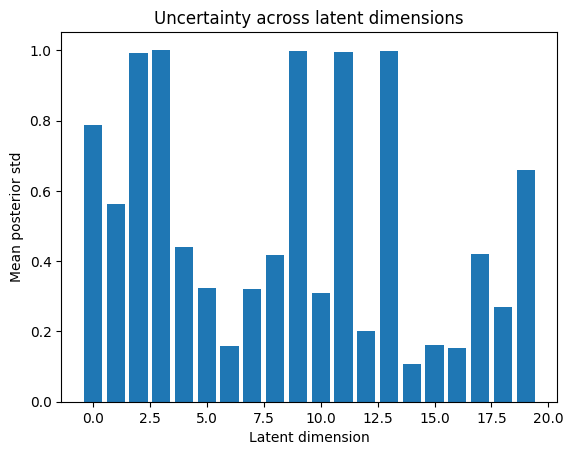

In [13]:
import matplotlib.pyplot as plt
plt.bar(range(len(posterior_std_per_dim)), posterior_std_per_dim)
plt.xlabel("Latent dimension")
plt.ylabel("Mean posterior std")
plt.title("Uncertainty across latent dimensions")
plt.savefig("outputs/posterior_std.png")
plt.show()
